In [17]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

from cnvm import Parameters, CNVM
from cnvm.collective_variables import OpinionShares
from cnvm.utils import sample_many_runs, calc_rre_traj


In [18]:
num_opinions = 2  # opinion 1 represents 'S', opinion 2 represents 'I'
num_agents = 1000
infection_rate = 0.5

r = np.array(
    [[0, infection_rate],
     [0, 0]]
)
r_tilde = np.array(
    [[0, 0],
     [1, 0]]
)

network = nx.erdos_renyi_graph(num_agents, p=0.1)

params = Parameters(
    num_opinions=num_opinions,
    network=network,
    r=r,
    r_tilde=r_tilde,
)

model = CNVM(params)
cv = OpinionShares(num_opinions, normalize=True)

In [19]:
t_max = 100
x_init = np.zeros(num_agents)
x_init[:int(num_agents * 0.3)] = 1
np.random.shuffle(x_init)

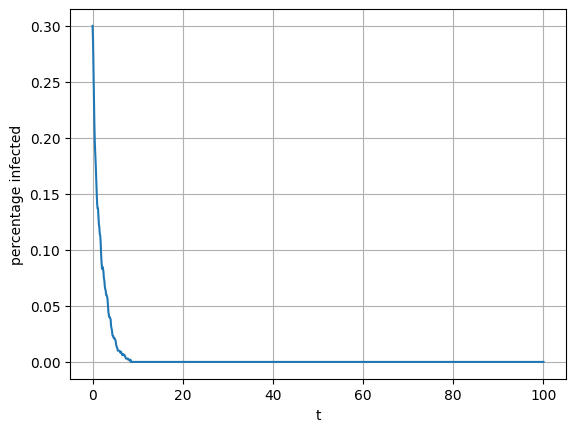

In [20]:
t, x = model.simulate(t_max=t_max, x_init=x_init, len_output=10 * t_max)
c = cv(x)

plt.plot(t, c[:, 1])
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

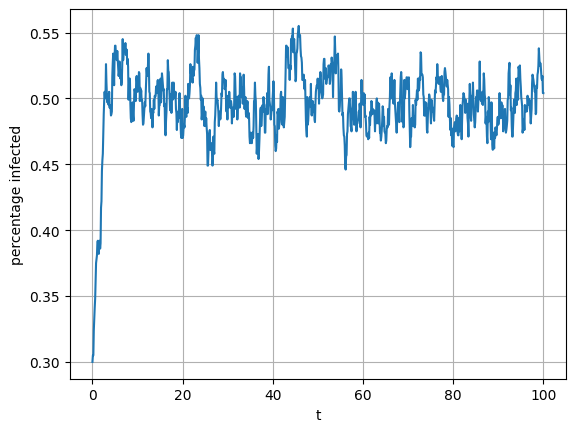

In [21]:
infection_rate = 2
r = np.array(
    [[0, infection_rate],
     [0, 0]]
)
model.update_rates(r=r)

t, x = model.simulate(t_max=t_max, x_init=x_init, len_output=10 * t_max)
c = cv(x)

plt.plot(t, c[:, 1])
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

In [22]:
infection_rates = [0.8, 0.9, 1.0, 1.1, 1.2]
c_results = []
for i_r in infection_rates:
    r = np.array([[0, i_r], [0, 0]])
    params.change_rates(r=r)
    t, c = sample_many_runs(
        params=params,
        initial_states=np.array([x_init]),
        t_max=t_max,
        num_timesteps=t_max,
        num_runs=100,
        collective_variable=cv,
        n_jobs=-1,
    )
    c_results.append(c)

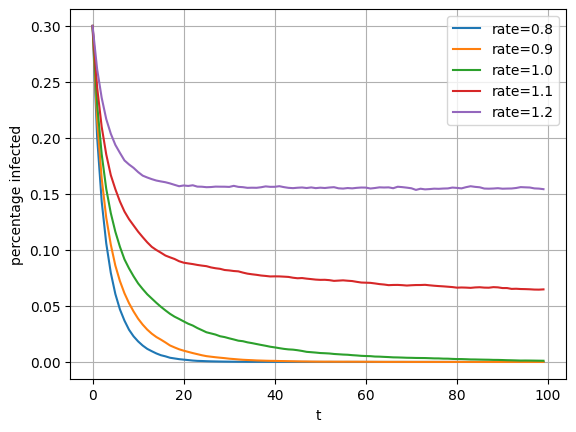

In [23]:
for i_r, c_r in zip(infection_rates, c_results):
    plt.plot(np.mean(c_r[0, :, :, 1], axis=0), label=f"rate={i_r}")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()

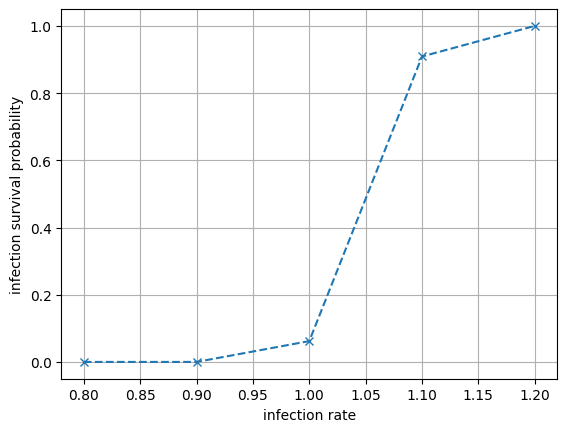

In [24]:
persistence_probabilities = [
    np.linalg.norm(c_r[0, :, -1, 1], 0) / c_r.shape[1] for c_r in c_results
]

plt.plot(infection_rates, persistence_probabilities, "--x")
plt.ylabel("infection survival probability")
plt.xlabel("infection rate")
plt.grid()
plt.show()

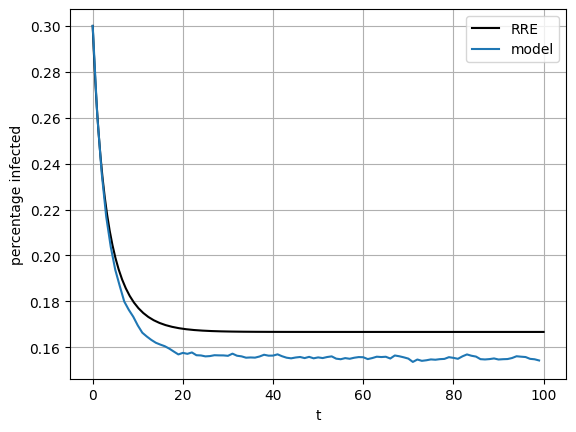

In [25]:
t_rre, c_rre = calc_rre_traj(params, c_results[-1][0, 0, 0], t_max)

plt.plot(t_rre, c_rre[:, 1], "-k", label="RRE")
plt.plot(np.mean(c_results[-1][0, :, :, 1], axis=0), label="model")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("percentage infected")
plt.show()